# Using VQCs in Machine Learning
### 05/07/2023 TQ Summer School
Let's try quantum machine learning in simple classification task. We will use scikit-learn's task [make_moons()](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) for this.

## Creating dataset

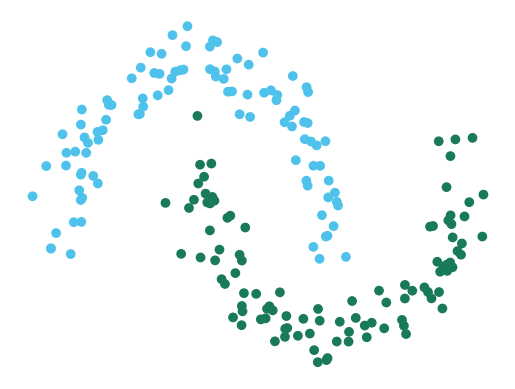

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.datasets import make_moons

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

X, y = make_moons(n_samples=200, noise=0.1)
y_ = torch.unsqueeze(torch.tensor(y), 1)  # used for one-hot encoded labels
y_hot = torch.scatter(torch.zeros((200, 2)), 1, y_, 1)

c = ["#4FC2EB" if y_ == 0 else "#197A57" for y_ in y]  # colours for each class
plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

## Defining QNode
Our next step is to define the QNode that we want to interface with `torch.nn`. Any combination of device, operations and measurements that is valid in PennyLane can be used to compose the QNode. However, the QNode arguments must satisfy additional [conditions](https://docs.pennylane.ai/en/stable/code/api/pennylane.qnn.TorchLayer.html) including having an argument called `inputs`. All other arguments must be arrays or tensors and are treated as trainable weights in the model. We fix a two-qubit QNode using the `default.qubit` simulator.

In [43]:
import pennylane as qml

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    # Embedding
    qml.AngleEmbedding(inputs, wires=range(n_qubits))

    # for i in range(len(inputs)):
    #     qml.RX(inputs[i], wires=i)

    # Entanglement
    for j in range(weights.shape[0]):
        for i in range(weights.shape[1]):
            qml.RY(weights[j][i], wires=i)

        for i in range(weights.shape[1] - 1):
            qml.CNOT(wires=[i, i + 1])

        qml.CNOT(wires=[weights.shape[1] - 1, 0])


    # Worth to use!
    # qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(weights.shape[1])]

## Interfacing with Torch
With the QNode defined, we are ready to interface with `torch.nn`. This is achieved using the `TorchLayer` class of the `qnn` module, which converts the QNode to the elementary building block of `torch.nn`: *a layer*.

We must first define the `weight_shapes` dictionary. Recall that all of the arguments of the QNode (except the one named inputs) are treated as trainable weights. For the QNode to be successfully converted to a layer in `torch.nn`, we need to provide the details of the shape of each trainable weight for them to be initialized. The weight_shapes dictionary maps from the argument names of the QNode to corresponding shapes:

In [44]:
n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}

Now that `weight_shapes` is defined, it is easy to then convert the QNode:

In [45]:
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

With this done, the QNode can now be treated just like any other torch.nn layer and we can proceed using the familiar Torch workflow.

## Creating a hybrid model
Let’s create a basic three-layered hybrid model consisting of:

1) a 2-neuron fully connected classical layer
2) our 2-qubit QNode converted into a layer
3) another 2-neuron fully connected classical layer
4) a softmax activation to convert to a probability vector

A diagram of the model can be seen in the figure below.

<img src="qnn_torch.png" alt="drawing" width="1200"/>

In [46]:
clayer_1 = torch.nn.Linear(2, 2)
clayer_2 = torch.nn.Linear(2, 2)
softmax = torch.nn.Softmax(dim=1)
layers = [clayer_1, qlayer, clayer_2, softmax]
model = torch.nn.Sequential(*layers)
model

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): <Quantum Torch Layer: func=qnode>
  (2): Linear(in_features=2, out_features=2, bias=True)
  (3): Softmax(dim=1)
)

## Training the model
We can now train our hybrid model on the classification dataset using the usual Torch approach. We’ll use the standard `SGD` optimizer and the mean absolute error loss function:

In [47]:
opt = torch.optim.SGD(model.parameters(), lr=0.2)
loss = torch.nn.L1Loss()

In [50]:
X = torch.tensor(X, requires_grad=True).float()
y_hot = y_hot.float()

batch_size = 5
batches = 200 // batch_size

data_loader = torch.utils.data.DataLoader(
    list(zip(X, y_hot)), batch_size=5, shuffle=True, drop_last=True
)

epochs = 10

for epoch in range(epochs):

    running_loss = 0

    for xs, ys in data_loader:
        opt.zero_grad()

        loss_evaluated = loss(model(xs), ys)
        loss_evaluated.backward()

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

y_pred = model(X)
predictions = torch.argmax(y_pred, axis=1).detach().numpy()

correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
print(f"Accuracy: {accuracy * 100}%")

C:\Users\asedi\AppData\Local\Temp\ipykernel_11612\3676203486.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, requires_grad=True).float()


Average loss over epoch 1: 0.1396
Average loss over epoch 2: 0.1419
Average loss over epoch 3: 0.1399
Average loss over epoch 4: 0.1414
Average loss over epoch 5: 0.1456
Average loss over epoch 6: 0.1465
Average loss over epoch 7: 0.1402
Average loss over epoch 8: 0.1385
Average loss over epoch 9: 0.1439
Average loss over epoch 10: 0.1449
Accuracy: 86.5%


## Plotting Decision Boundaries

In [67]:
x_min, x_max = X[:, 0].min() - 0.1, X[:,0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

In [68]:
xx, yy = np.meshgrid(np.linspace(x_min.detach().numpy(), x_max.detach().numpy(), 100), np.linspace(y_min.detach().numpy(), y_max.detach().numpy(), 100))
x_in = np.c_[xx.ravel(), yy.ravel()]

In [69]:
model.eval()
x_in = torch.tensor(x_in).float()
y_pred = model(x_in)

In [70]:
y_pred = np.round(y_pred[:, 1].detach().numpy()).reshape(xx.shape)

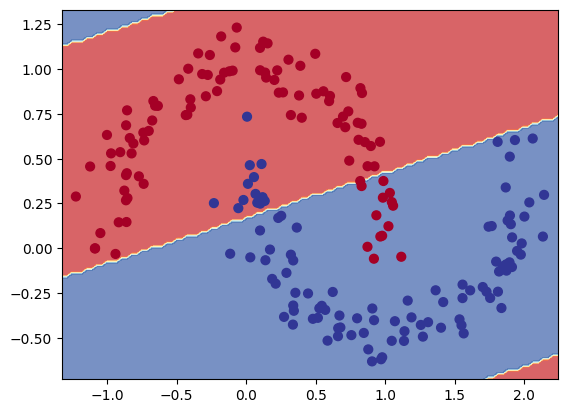

In [71]:
plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7 )
plt.scatter(X[:, 0].detach().numpy(), X[:, 1].detach().numpy(), c=y, s=40, cmap=plt.cm.RdYlBu)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
pass

Looks like Linear Regression XD